In [5]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [6]:
train_path = 'speech-based-classification-layer-10/train.csv'
valid_path = 'speech-based-classification-layer-10/valid.csv'
test_path = 'speech-based-classification-layer-10/test.csv'
train = pd.read_csv(train_path)
valid = pd.read_csv(valid_path)
test = pd.read_csv(test_path)
original_train = train.copy()
original_valid = train.copy()
original_test = test.copy()

# Label Data

In [7]:
train_features = train.iloc[:, :768]
train_label_3 = train.iloc[:, 770]

valid_features = valid.iloc[:, :768]
valid_label_3 = valid.iloc[:, 770]

test_features = test.iloc[:, :768]

Class Distribution Plot

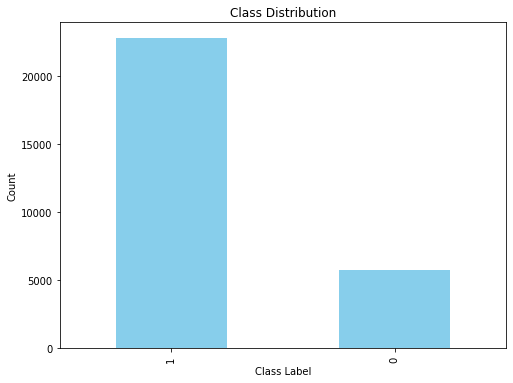

In [9]:
class_counts = train_label_3.value_counts()
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')

plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution')


plt.show()

From SVM and Random Forest classifiers choosing the best classification model
1. Stratified K Fold model is used for cross validation
2. Default parameters of classifcation models are used
3. Since classes are not  balanced f1 score is used for the evaluation

In [13]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



classifiers = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
}


best_model = None
best_accuracy = 0.0


n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)

for name, clf in classifiers.items():
    total_score = 0.0

    for train_index, test_index in skf.split(train_features, train_label_3):
        X_train, X_test = train_features.iloc[train_index], train_features.iloc[test_index]
        y_train, y_test = train_label_3[train_index], train_label_3[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        f1_score_ = f1_score(y_test, y_pred)
        total_score += f1_score_

    average_score = total_score / n_splits
    print(f"{name} - Average F1 Score: {average_score}")


    if average_score > best_accuracy:
        best_model = clf
        best_accuracy = average_score

print(f"Best Model: {type(best_model).__name__}")

Random Forest - Average F1 Score: 0.9560235569456126
SVM - Average F1 Score: 0.9916433701082183
Best Model: SVC


Addressing Class Imbalance Issues
1. Use SMOTE oversampling to address class imbalance issue

In [15]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
train_feature_resampled, train_label_3_resampled = smote.fit_resample(train_features, train_label_3)

Accuracy after oversampling

In [16]:
model = SVC()
model.fit(train_feature_resampled, train_label_3_resampled)
predictions = model.predict(valid_features)
print(f"Accuracy: {f1_score(valid_label_3, predictions)}")

Accuracy: 0.9975267930750207


Feature Scaling

In [17]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler()
scaled_train_features = transformer.fit_transform(train_feature_resampled)
scaled_valid_features = transformer.fit_transform(valid_features)
scaled_test_features = transformer.fit_transform(test_features)

PCA Transformation 

In [19]:
from sklearn.decomposition import PCA

def performPca(train_input, valid_input,test_input, n_components):
    pca = PCA(n_components=n_components)
    train_reduced = pca.fit_transform(train_input)
    valid_reduced = pca.transform(valid_input)
    test_reduced = pca.transform(test_input)
    train_reduced_df = pd.DataFrame(train_reduced, columns=[f"new_feature_{i+1}" for i in range(train_reduced.shape[1])])
    valid_reduced_df = pd.DataFrame(valid_reduced, columns=[f"new_feature_{i+1}" for i in range(valid_reduced.shape[1])])
    test_reduced_df = pd.DataFrame(test_reduced, columns=[f"new_feature_{i+1}" for i in range(test_reduced.shape[1])])


    return train_reduced_df, valid_reduced_df,test_reduced_df

In [20]:
train_reduced_df, valid_reduced_df,test_reduced_df = performPca(scaled_train_features, scaled_valid_features, scaled_test_features, 0.99)

In [21]:
model_ = SVC()
model_.fit(train_reduced_df, train_label_3_resampled)
y_pred = model_.predict(valid_reduced_df)
accuracy = f1_score(valid_label_3, y_pred)
print(f"F1 Score: {accuracy}")

F1 Score: 0.9712351945854484


In [22]:
test_predictions = model_.predict(test_reduced_df)

In [23]:
#Write to file
test_pred_df = pd.DataFrame(test_predictions, columns=['label_3'])
test_pred_df.to_csv('predictions/label_3.csv', index=False)